# Bell Pepper Leaves Disease Detection

## Import Dependencies

In [26]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
import joblib

In [2]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    "PepperPlant",
    shuffle=True,
    image_size=(256, 256),
    batch_size=30,
)

Found 2475 files belonging to 2 classes.


In [3]:
class_names = data.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

## Splitting the data

- train data = 0.8
- test data = 0.2 --> validation data = 0.1 and test data = 0.1

In [4]:
def data_split(data, train_split=0.8, val_split=0.1, test_data=0.1, shuffle=True, shuffle_size=1000):
    data_size = len(data)
    
    if shuffle:
        data = data.shuffle(shuffle_size, seed=10)
    
    train_size = int(train_split * data_size)
    val_size = int(val_split * data_size)
    
    train_data = data.take(train_size)
    val_data = data.skip(train_size).take(val_size)
    test_data = data.skip(train_size).skip(val_size)
    
    return train_data, val_data, test_data


In [5]:
train_data, val_data, test_data = data_split(data)

In [6]:
print(f"Actual Data: {len(data)}")
print(f"Train data: {len(train_data)} + Validation_data: {len(val_data)} + Test data: {len(test_data)} = {len(train_data) + len(val_data) + len(test_data)}")

Actual Data: 83
Train data: 66 + Validation_data: 8 + Test data: 9 = 83


## Scaling the data

In [7]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256, 256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

## Model building

In [8]:
model = tf.keras.Sequential([
    resize_and_rescale,
    layers.Conv2D(30, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(60, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Flatten(),
    layers.Dense(80, activation='relu'),
    layers.Dense(2, activation='softmax')
])
model.build(input_shape=(30,256,256,3))

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (30, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (30, 254, 254, 30)        840       
                                                                 
 max_pooling2d (MaxPooling2  (30, 127, 127, 30)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (30, 125, 125, 60)        16260     
                                                                 
 max_pooling2d_1 (MaxPoolin  (30, 62, 62, 60)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (30, 230640)             

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [11]:
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [12]:
early_stoppping = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

In [13]:
model_history = model.fit(
    train_data,
    epochs=10,
    batch_size=30,
    verbose=1,
    validation_data=val_data,
    callbacks=early_stoppping
)

Epoch 1/10
66/66 [==============================] - 115s 2s/step - loss: 0.6132 - accuracy: 0.6803 - val_loss: 0.4136 - val_accuracy: 0.8625
Epoch 2/10
66/66 [==============================] - 101s 2s/step - loss: 0.3907 - accuracy: 0.8298 - val_loss: 0.3592 - val_accuracy: 0.8167
Epoch 3/10
66/66 [==============================] - 98s 1s/step - loss: 0.3094 - accuracy: 0.8677 - val_loss: 0.2963 - val_accuracy: 0.8875
Epoch 4/10
66/66 [==============================] - 99s 1s/step - loss: 0.2756 - accuracy: 0.8784 - val_loss: 0.2098 - val_accuracy: 0.9167
Epoch 5/10
66/66 [==============================] - 98s 1s/step - loss: 0.2346 - accuracy: 0.9059 - val_loss: 0.1846 - val_accuracy: 0.9292
Epoch 6/10
66/66 [==============================] - 100s 1s/step - loss: 0.2154 - accuracy: 0.9232 - val_loss: 0.1971 - val_accuracy: 0.9156
Epoch 7/10
66/66 [==============================] - 99s 1s/step - loss: 0.2078 - accuracy: 0.9232 - val_loss: 0.1585 - val_accuracy: 0.9542
Epoch 8/10
66/66 

- Can increase the `Epochs` to reduce the loss (if needed)

## Plotting the loss and accuracy score

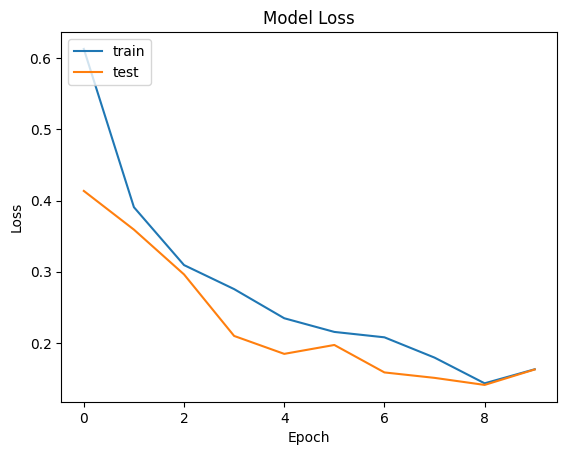

In [14]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

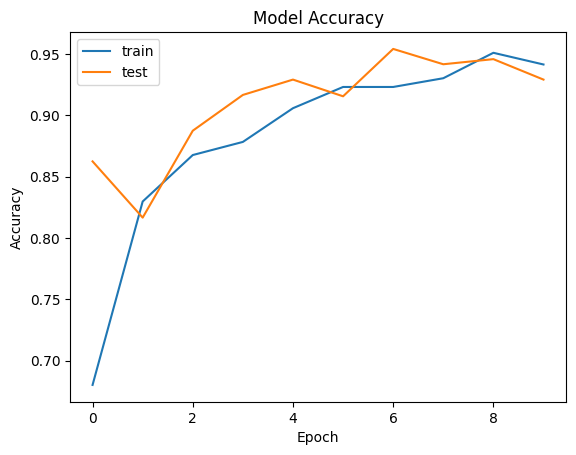

In [15]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluating the model

In [16]:
loss, accuracy = model.evaluate(test_data)
print(f"Loss: {loss}\nAccuracy: {accuracy}")

9/9 [==============================] - 4s 283ms/step - loss: 0.1753 - accuracy: 0.9481
Loss: 0.17534096539020538
Accuracy: 0.9481481313705444


## Actual label and Predicted label

Actual label: Pepper__bell___Bacterial_spot
1/1 [==============================] - 0s 170ms/step
Predicted label: Pepper__bell___Bacterial_spot


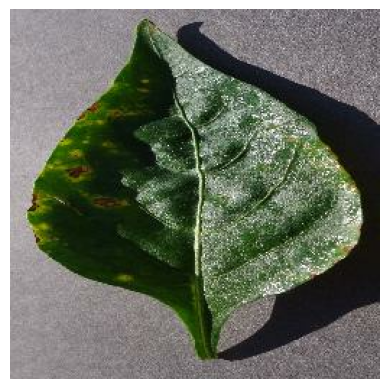

In [22]:
for images_batch, labels_batch in test_data.take(1):
    
    actual_image = images_batch[0].numpy().astype("uint8")
    actual_label = labels_batch[0].numpy()
    
    plt.imshow(actual_image)
    plt.axis("off")
    actual_class_index = np.argmax(actual_label)
    print(f"Actual label: {class_names[actual_class_index]}")
    
    predtiction = model.predict(images_batch)
    print(f"Predicted label: {class_names[np.argmax(predtiction[0])]}")
#     print(predtiction[0])

## Confidence percentage on Actual label and Predicted label

In [47]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 43ms/step


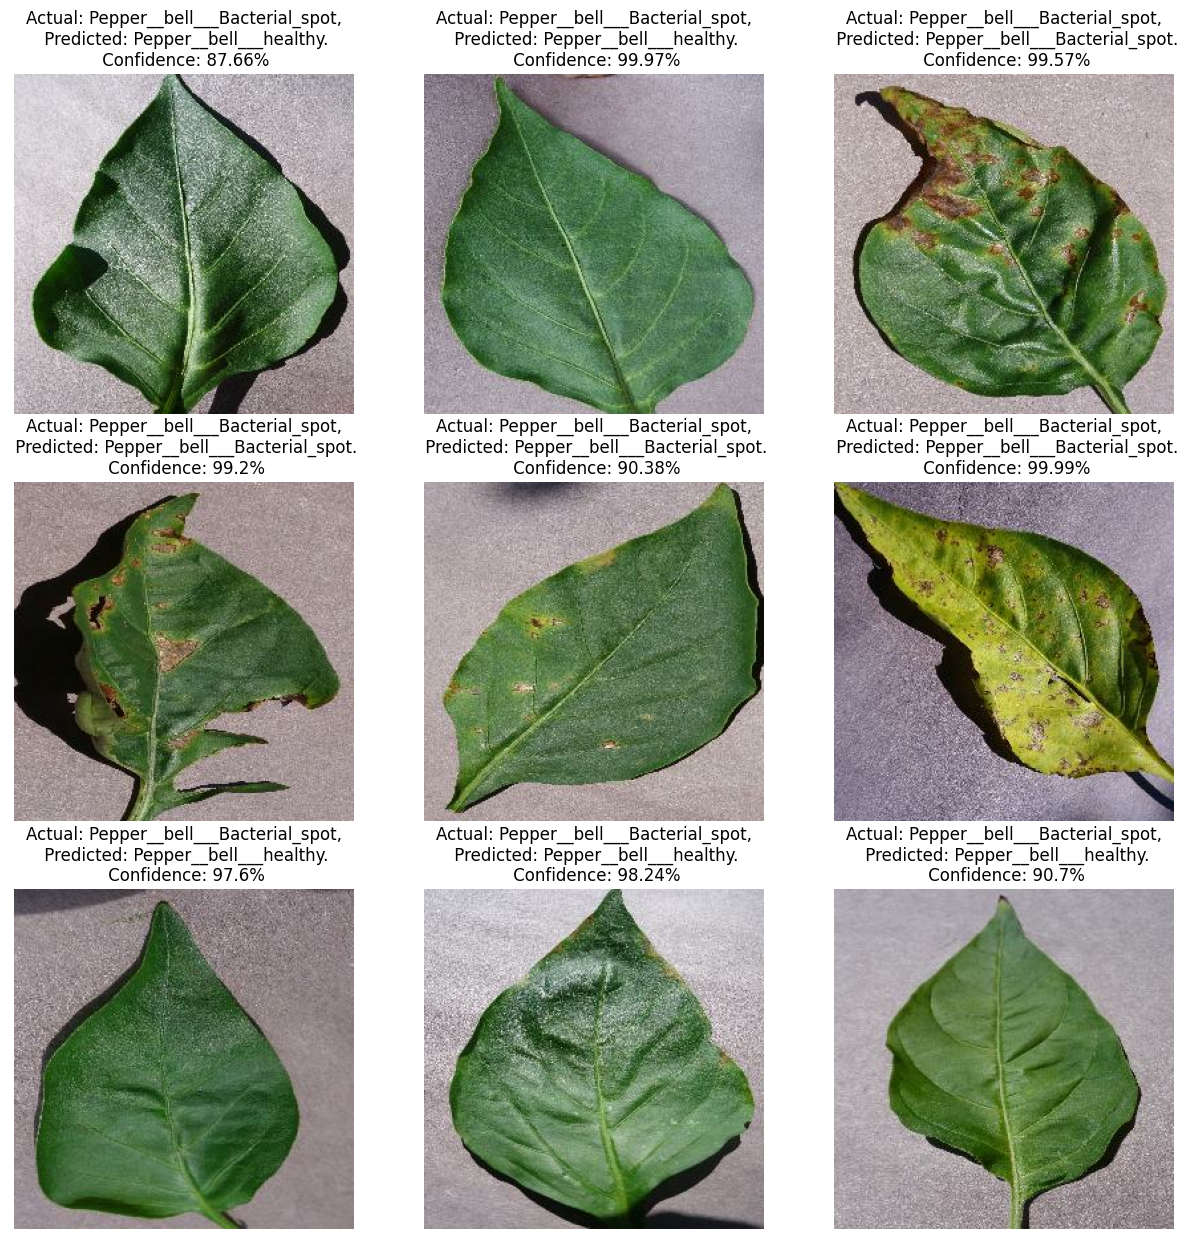

In [48]:
plt.figure(figsize=(15, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[np.argmax(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Save the model

In [23]:
model.save_weights('pepper_weight.h5')

In [24]:
model.save('pepper_model1.h5')

C:\Users\sprav\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Predictive System

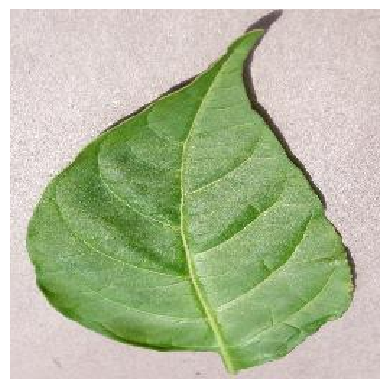

1/1 [==============================] - 0s 89ms/step
Pepper plant is healthy


In [27]:
def main():
    
    image_path = "PlantVillage/pepper-healthy2.JPG"
    img = image.load_img(image_path, target_size=(256,256))
    plt.imshow(img, interpolation='nearest')
    plt.axis("off")
    plt.show()
    
    img_array = np.array(img)
    img_array = img_array.reshape(1, 256, 256, 3)
#     model = joblib.load(open('pepper_model1.h5', 'rb'))
    model = load_model('pepper_model1.h5')
    prediction = model.predict(img_array)
    
    label = np.argmax(prediction[0])
    
    if label == 0:
        print("Pepper plant is afftected by bacteria")
    else:
        print("Pepper plant is healthy")
        
if __name__ == "__main__":
    main()